# Analysis Template

## Preprocess

In [3]:
# resolve dependency
# !pip install pmdarima

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pmdarima.arima import ADFTest , auto_arima
%matplotlib inline

In [5]:
data_path = "../data/nypd_larceny.csv"
crime = "type2"
target = "count"
date = "date"
city = "merged"
fig_size = (20,5)

In [6]:
df_by_day_nyc = pd.read_csv(data_path)
df_by_day_nyc[date] = pd.to_datetime(df_by_day_nyc[date])
df_by_day_nyc.set_index(date, inplace=True)

In [7]:
data_path = "../data/theft_occurrence_per_day.csv"
target = "Count"
date = "Date"

In [8]:
df_by_day_chi = pd.read_csv(data_path)
df_by_day_chi[date] = pd.to_datetime(df_by_day_chi[date])
df_by_day_chi.set_index(date, inplace=True)

In [9]:
df_by_day=df_by_day_nyc.join(df_by_day_chi,how='inner')

In [10]:
df_by_day[target]=df_by_day[target]+df_by_day['count']
df_by_day.drop('count',axis=1,inplace=True)

In [11]:
df_by_day

,Count
2006-01-01,534
2006-01-02,214
2006-01-03,260
2006-01-04,277
2006-01-05,243
...,...
2021-12-27,159
2021-12-28,172
2021-12-29,185
2021-12-30,177


## Profiling

### By day

In [12]:
df_by_day.head()

,Count
2006-01-01,534
2006-01-02,214
2006-01-03,260
2006-01-04,277
2006-01-05,243


In [13]:
df_by_day.describe()

,Count
count,5844.000000
mean,253.156571
std,55.191242
min,54.000000
25%,222.000000
50%,260.000000
75%,290.000000
max,582.000000


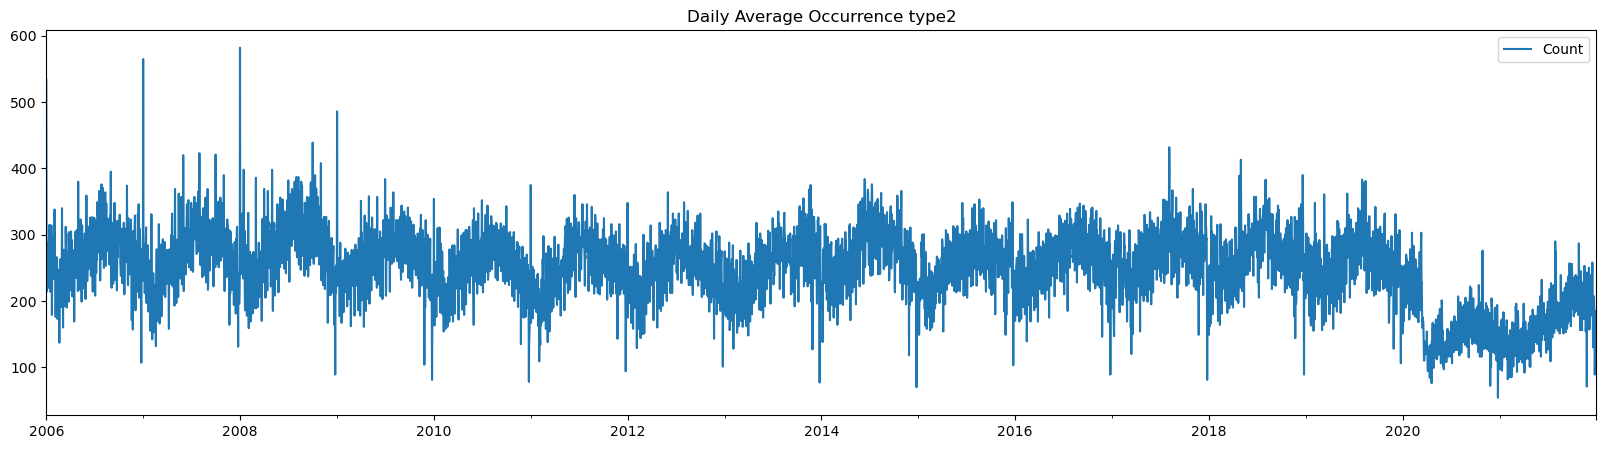

In [14]:
df_by_day.plot(figsize=fig_size, title="Daily Average Occurrence " + crime)
plt.show()

In [15]:
df_by_day[target].sort_values(ascending=False).head()

2008-01-01    582
2007-01-01    565
2006-01-01    534
2009-01-01    486
2008-10-01    439
Name: Count, dtype: int64

### By week

In [16]:
df_by_week = pd.DataFrame(df_by_day[target].resample('W').mean())

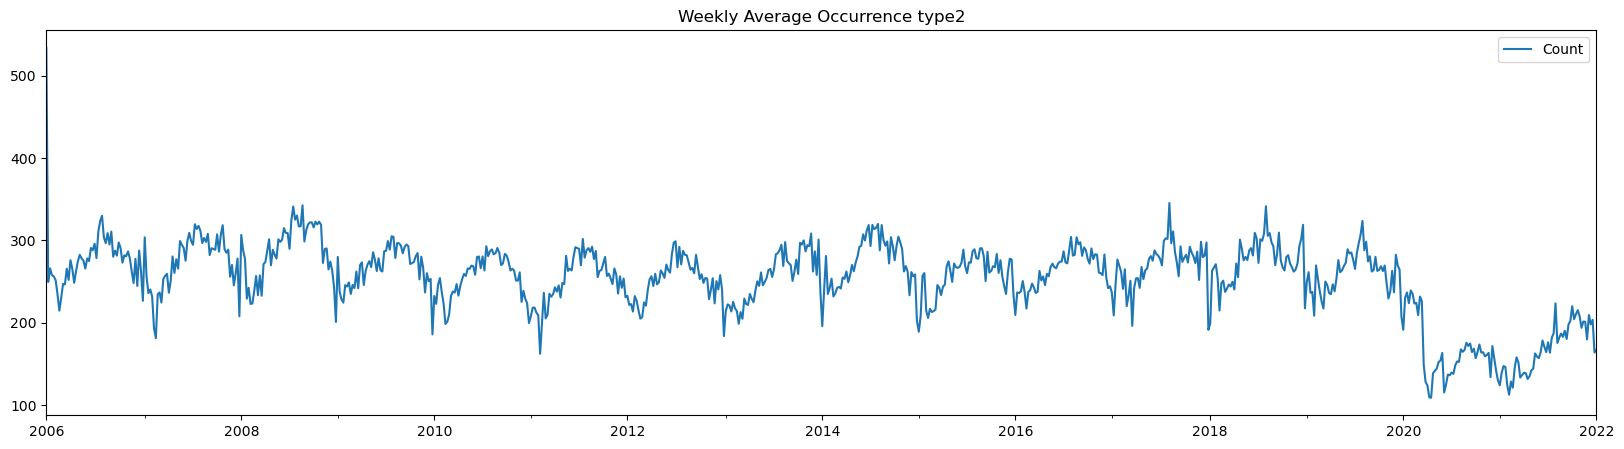

In [17]:
df_by_week.plot(
    figsize=fig_size,
    title="Weekly Average Occurrence " + crime)
plt.show()

### By month

In [18]:
df_by_month = pd.DataFrame(df_by_day[target].resample('M').mean())

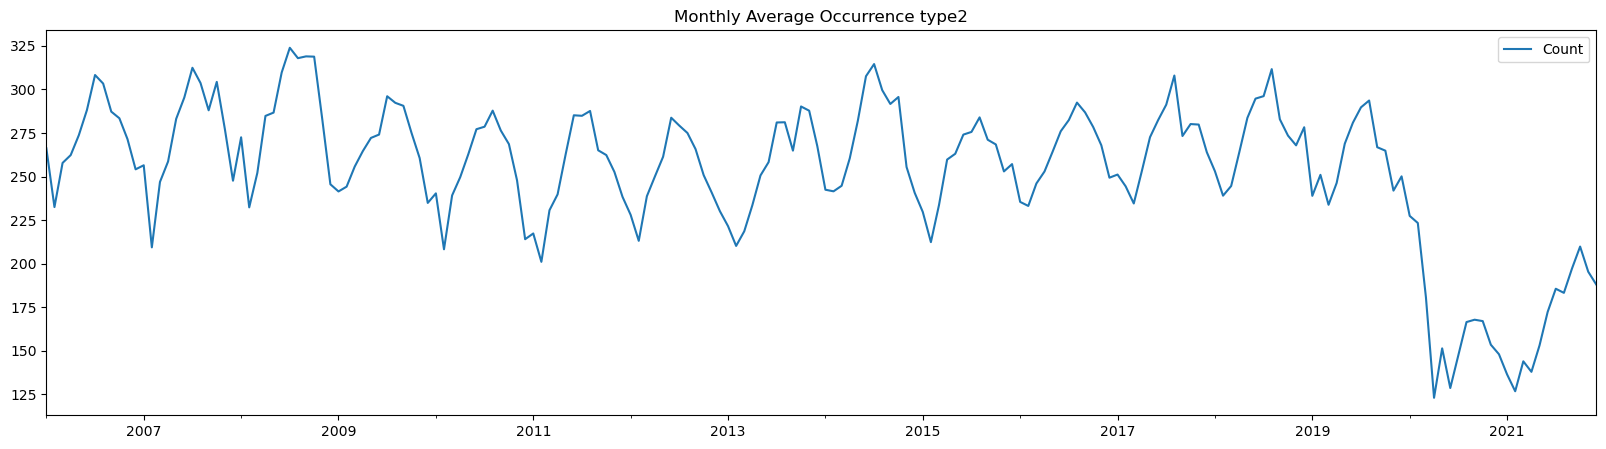

In [19]:
df_by_month.plot(
    figsize=fig_size, 
    title="Monthly Average Occurrence " + crime)
plt.show()

## Analysis

In [20]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(count):
    result=adfuller(count)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

### Checking stationary

In [21]:
adfuller_test(df_by_month[target])

ADF Test Statistic : -2.514806277975161
p-value : 0.1119132343832625
#Lags Used : 14
Number of Observations Used : 177
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Checking seasonality

In [22]:
df_by_month['seasonal_first_difference'] = df_by_month[target] - df_by_month[target].shift(12)

In [23]:
adfuller_test(df_by_month['seasonal_first_difference'].dropna())

ADF Test Statistic : -2.9970129814133006
p-value : 0.035174293391614146
#Lags Used : 12
Number of Observations Used : 167
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: title={'center': 'Seasonal difference plot - type2'}>

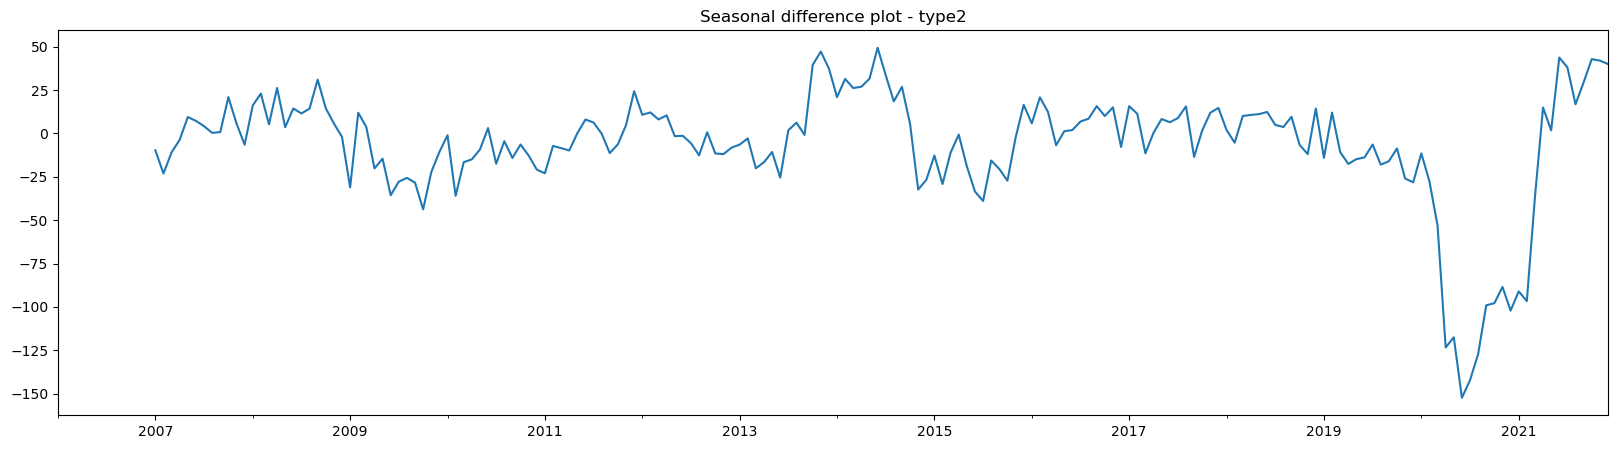

In [24]:
df_by_month['seasonal_first_difference'].plot(figsize=fig_size, title='Seasonal difference plot - ' + crime)

### Auto Regressive Model

/Users/xuyanchong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


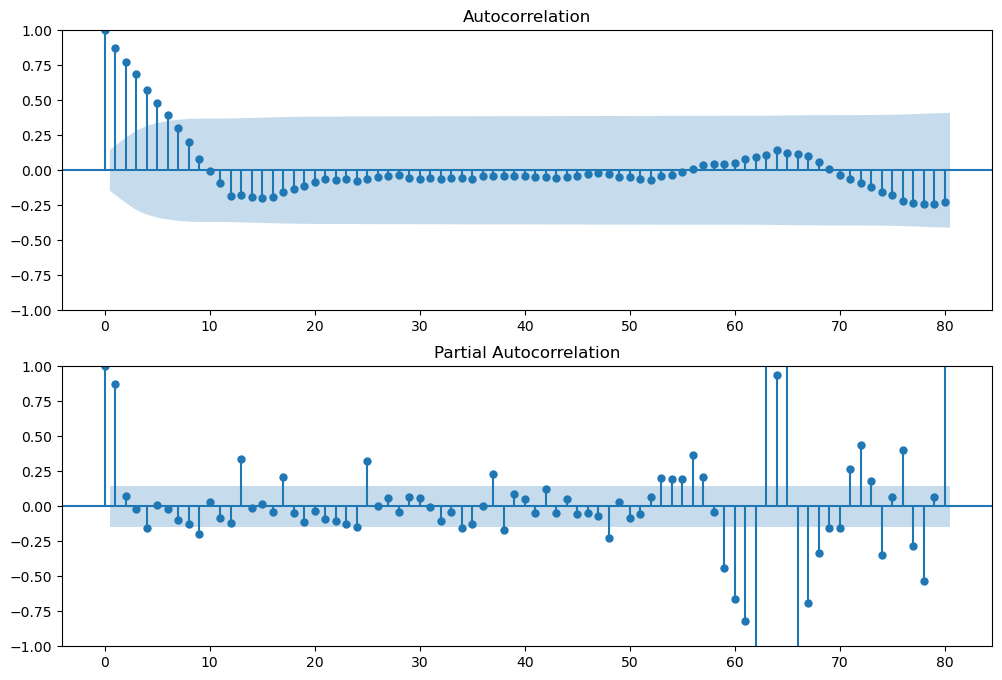

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_by_month['seasonal_first_difference'].iloc[13:],lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_by_month['seasonal_first_difference'].iloc[13:],lags=80,ax=ax2)

### Implementing Seasonal Arima Model

In [26]:
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df_by_month[target])

(0.24971947570380035, True)

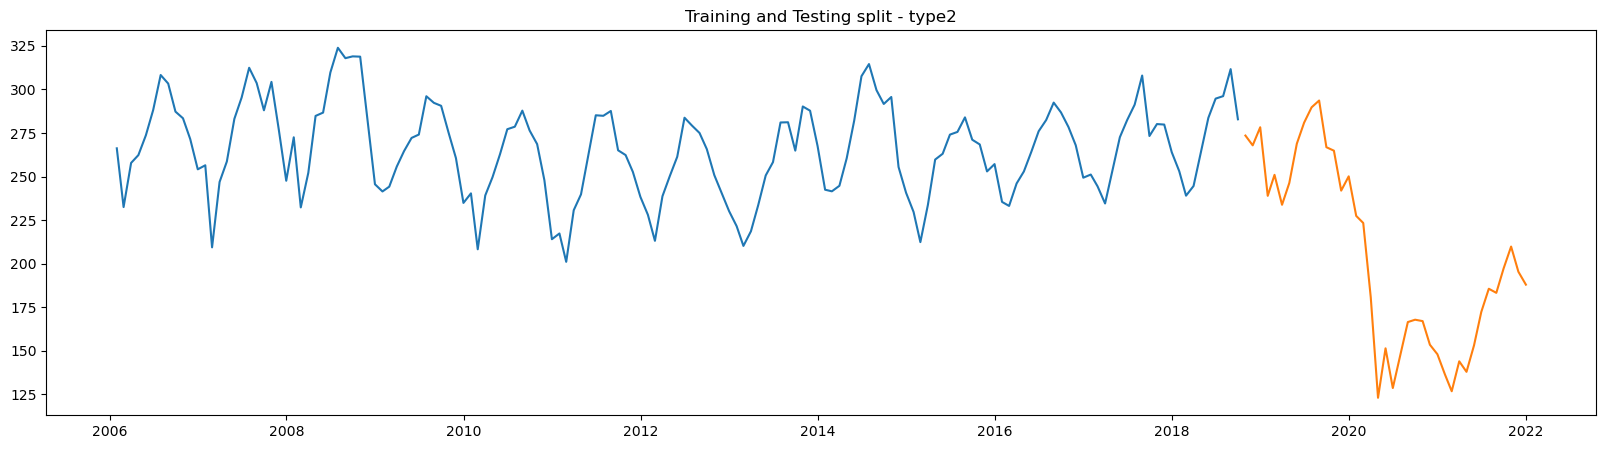

In [27]:
start=int(df_by_month.shape[0]*0.8)
train=df_by_month[:start]
test=df_by_month[start:]
plt.figure(figsize=fig_size)
plt.plot(train[target])
plt.plot(test[target])
plt.title('Training and Testing split - '+ crime)
plt.show()

In [28]:
model=auto_arima(train[target],start_p=0,d=1,start_q=0,
          max_p=10,max_d=10,max_q=10, start_P=0,
          D=1, start_Q=0, max_P=10,max_D=10,
          max_Q=10, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1137.784, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1099.361, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1069.905, Time=2.25 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1123.961, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1071.875, Time=4.21 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1071.869, Time=16.64 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1092.129, Time=0.61 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=56.60 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1090.088, Time=1.17 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1070.139, Time=2.34 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1069.854, Time=2.71 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1123.095, Time=0.46 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=1071.742, Time=3.50 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1071.716, Time=15.86 sec
 ARIMA(0,1,2)(1,1,0)[

In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  153
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -530.927
Date:                              Sun, 23 Apr 2023   AIC                           1069.854
Time:                                      01:34:30   BIC                           1081.621
Sample:                                  01-31-2006   HQIC                          1074.636
                                       - 09-30-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4122      0.073     -5.658      0.000      -0.555      -0.269
ma.L2         -0.1338      0.091     -1.478      0.139      -0.311       0.044
ma.S.L12      -0.7141      0.076     -9.450      0.000      -0.862      -0.566
sigma2       108.1566     12.706      8.512      0.000      83.253     133.060
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.71
Prob(Q):                              0.85   Prob(JB):                         0.26
Heteroskedasticity (H):               0.84   Skew:                             0.23
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

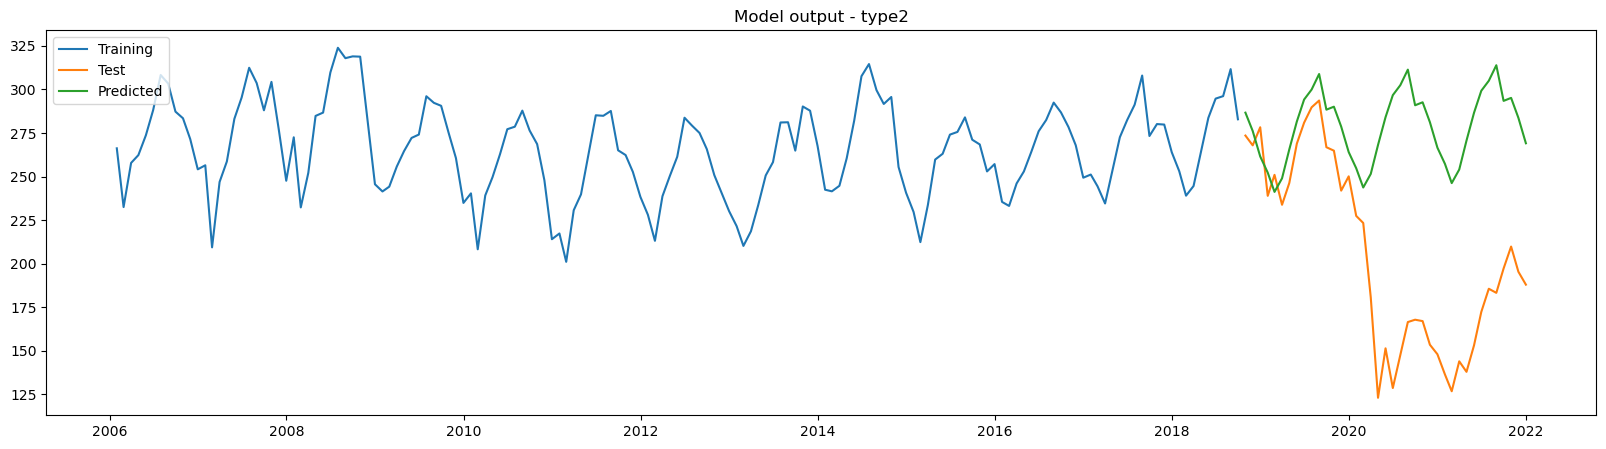

In [30]:
prediction = pd.DataFrame(model.predict(n_periods = train.shape[0]),index=test.index)
prediction.columns = ['predicted_crime']
plt.figure(figsize=fig_size)
plt.plot(train[target],label="Training")
plt.plot(test[target],label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('../output/%s_%s_pred.jpg' % (city,crime))
plt.title('Model output - '+crime)
plt.show()

In [31]:
np.sqrt(np.square(np.subtract(test[target].values,prediction['predicted_crime'].values)).mean())

93.26660711161982